In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

from modelbase.ode import Simulator

import sys
sys.path.append("../Code")

# Import model functions
from get_current_model import get_model
from function_residuals import calculate_residuals, calculate_residuals_ePathways, integrator_kwargs
from robustness_fit_parameters import get_fitting_parameter_dict, p_names
import functions_light_absorption as lip

# Monte Carlo analysis

In [4]:
run = "montecarlo_202405131529"

mcpar = pd.read_csv(Path("../Results")/ (run + "_params.csv"), index_col=0)
mcres = pd.read_csv(Path("../Results")/ (run + "_results.csv"), index_col=0)

In [19]:
# Residual functions
residual_names = {
    'LET_fraction' : "LET ~ 65%",
    'LET_flux': "LET ~ 15 e/PSI/s",
    'Schuurmans_O2': "Schuurmans O2 data",
    'Benschop_O2': "Benschop O2 data",
    "PAMSP435_Fm'": "fitting PAM-SP data: Fm'",
    'PAMSP435_left': "fitting PAM-SP data: left Fs",
    'PAMSP435_right': "fitting PAM-SP data: right Fs",
    "PAMSPval_Fm'": "validation PAM-SP data: Fm'",
    'PAMSPval_left': "validation PAM-SP data: left Fs",
    'PAMSPval_right': "validation PAM-SP data: right Fs",
}

In [20]:
# Summary
mcres_outcomes = pd.DataFrame(index=mcres.index, columns=["success", "failed", "time-out"])

mcres_outcomes["timeout"] = np.isnan(mcres).any(axis=1)
mcres_outcomes["failed"] = np.isinf(mcres).any(axis=1)
mcres_outcomes["success"] = mcres_succ = np.invert(np.logical_or(mcres_outcomes["timeout"], mcres_outcomes["failed"]))

print(f"""Full runs: {mcres_outcomes['success'].sum()}
Time-outs: {mcres_outcomes['timeout'].sum()}
Failed: {mcres_outcomes['failed'].sum()}"""
)

Full runs: 9527
Time-outs: 474
Failed: 0


In [21]:
# Find simulations with improved objective functions
mcres_improved = mcres.copy()
mcres_improved = mcres_improved - mcres_improved.iloc[0,:]

# Find simulations with improvement in all objective functions
mcres_outcomes["total_better"] = (mcres_improved < 0).all(axis=1)

# Find simulations with improvement in all objective functions
mcres_outcomes["similar_pareto"] = (mcres_improved < 0.1).all(axis=1)

print(f"""Better runs (all residuals lower): {mcres_outcomes['total_better'].sum()}
Similar runs (all residuals max + 10%): {mcres_outcomes['similar_pareto'].sum()}"""
)

Better runs (all residuals lower): 0
Similar runs (all residuals max + 10%): 19


In [157]:
outcome_sets = {
    "total_better": ["all residuals improved", "red"],
    "similar_pareto": ["all residuals max 10% higher", "orange"],
}

In [22]:
mcpar_flat = mcpar.copy()

# Evaluate the strings in fluo_influence as their dict values are stored as string
# Not a goor practice
mcpar_flat["fluo_influence"] = mcpar_flat["fluo_influence"].apply(eval)

# Unpack the fluo influence parameters 
_fluo_influence = pd.DataFrame(mcpar_flat["fluo_influence"].to_dict()).T
_fluo_influence.columns = "fluo_influence_" + _fluo_influence.columns

# Append them to the parameters
mcpar_flat = pd.concat([mcpar_flat, _fluo_influence], axis=1)
mcpar_flat = mcpar_flat.drop("fluo_influence", axis=1)

In [23]:
# Normalise the parameters
mcpar_fnorm = mcpar_flat.copy()
mcpar_fnorm = mcpar_fnorm / mcpar_fnorm.iloc[0,:]


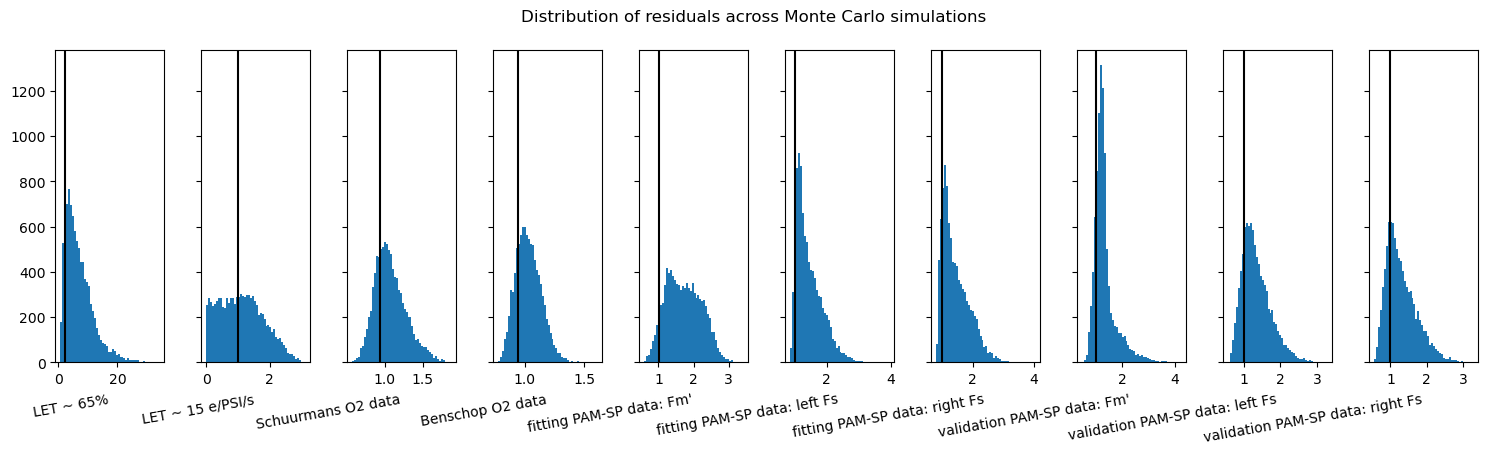

In [159]:
# Visualise the overall distribution

fig, axes = plt.subplots(1, mcres.shape[1], figsize=(15,4), sharey=True)
fig.suptitle("Distribution of residuals across Monte Carlo simulations")

for i, ((nam, val), ax) in enumerate(zip(mcres.T.iterrows(), axes.flatten())):
    ax.hist(val[mcres_succ], bins=50)
    ax.axvline(mcres.loc[0,nam], c="k")

    if i==0:
        fig.tight_layout()
    ax.set_xlabel(residual_names[nam], rotation=10, ha="right")



Text(0.5, 0.89, 'Comparison of residuals across Monte Carlo simulations\n9527 simulations with 26 parameters randomly varied within a factor 2.0 higher or lower')

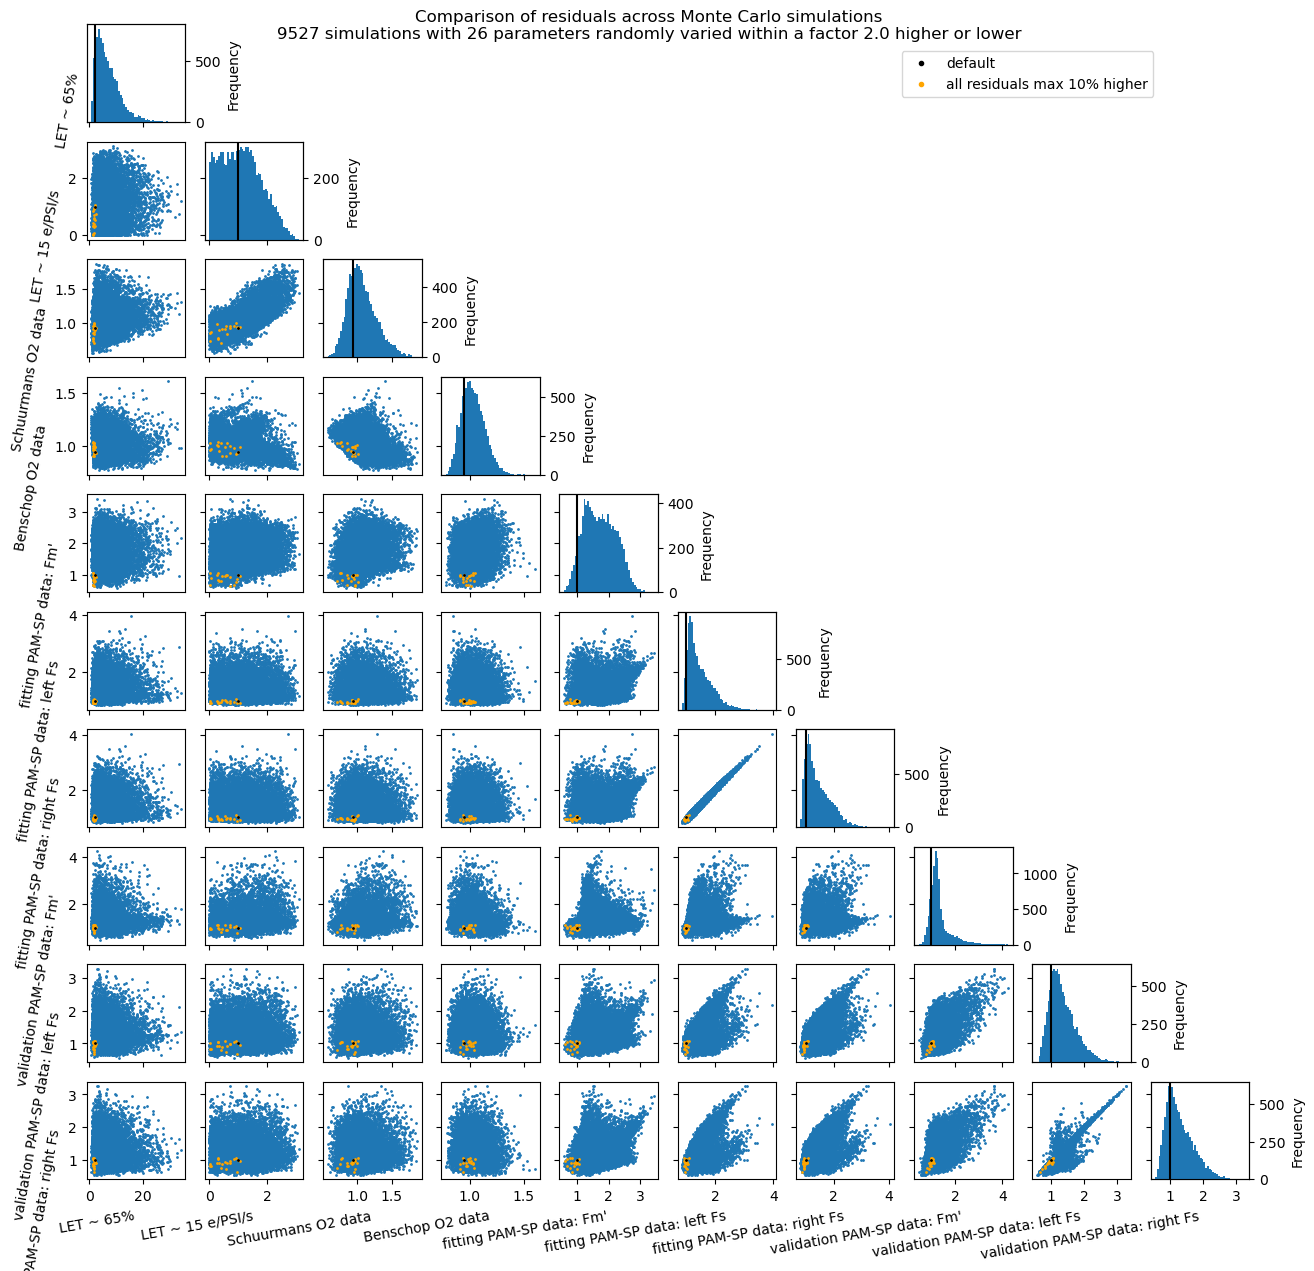

In [173]:
# Plot the pairwise comparison of model objectives
fig, axes = plt.subplots(
    mcres.shape[1],
    mcres.shape[1],
    figsize=(15,15),
    sharey="row",
    sharex="col"
)

# Plot the pariwise comparisons as scatter plots
for i, (nam_i, val_i) in enumerate(mcres.T.iterrows()):
    for j, (nam_j, val_j) in enumerate(mcres.T.iterrows()):
        # On the diagonal plot histograms
        if i==j:
            ax2 = axes[i,j].twinx()
            ax2.hist(val_i[mcres_succ], bins=50)
            ax2.set_ylabel("Frequency")

            # Mark the default
            ax2.axvline(val_i[0], c="k")

        
        # Plot scatter plots of the residuals
        elif i>j:
            axes[i,j].plot(
                val_j,
                val_i,
                marker="o",
                markersize=1,
                linestyle="",
            )

            for res_set in ["total_better", "similar_pareto"]:
            # Highlight the sets close to pareto optimum
                if mcres_outcomes[res_set].any():
                    axes[i,j].plot(
                        val_j[mcres_outcomes[res_set]],
                        val_i[mcres_outcomes[res_set]],
                        marker="o",
                        markersize=1,
                        linestyle="",
                        c=outcome_sets[res_set][1],
                        label=outcome_sets[res_set][0]
                    )

            # Highlight the default set
            axes[i,j].plot(
                val_j[0],
                val_i[0],
                marker="o",
                markersize=1,
                linestyle="",
                c="black",
                label="default"
            )

        else:
            # Remove plots above the diagonal
            axes[i,j].remove()

# Set the y label on the rows and x label on columns
for i in range(mcres.shape[1]):
    axes[i,0].set_ylabel(residual_names[mcres.columns[i]], rotation=80, va="bottom", ha="right")
    axes[-1,i].set_xlabel(residual_names[mcres.columns[i]], rotation=10, ha="right")

# Add a legend
axes[1,0].legend(
    bbox_to_anchor=(10.9,2),
    loc="upper right",
    markerscale=3,
    reverse=True
)

# Remove left axis of first plot
axes[0,0].set_yticks([])

fig.suptitle(f"Comparison of residuals across Monte Carlo simulations\n{mcres_succ.sum()} successful simulations with {mcpar_flat.shape[1]} parameters randomly varied within a factor {np.round(mcpar_flat.iloc[:,1].max() / mcpar_flat.iloc[:,1].min(),1)/2} higher or lower", y=0.89)
# fig.tight_layout()

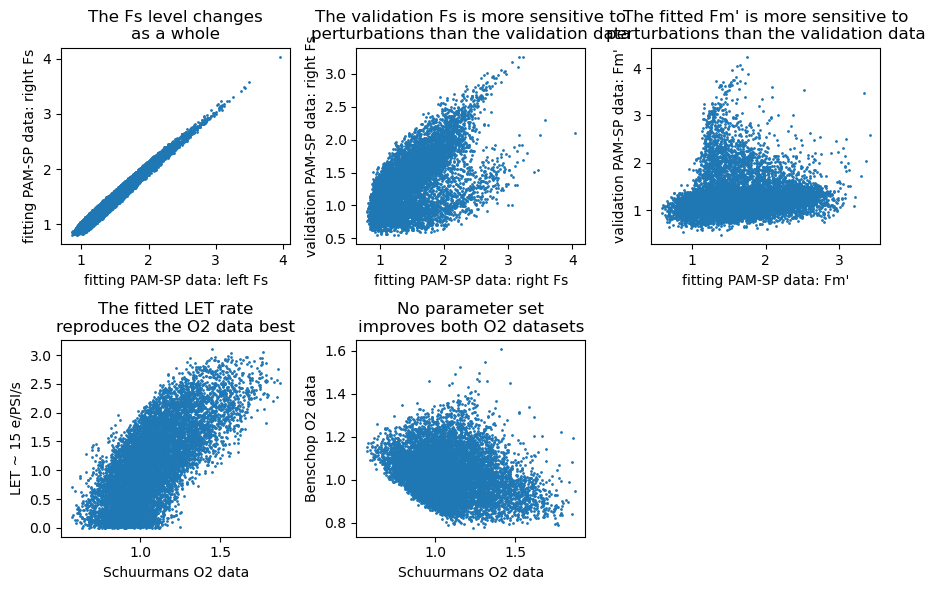

In [144]:
interesting_pairs = {
    "The Fs level changes\nas a whole": ["PAMSP435_left", "PAMSP435_right"],
    # ["PAMSPval_left", "PAMSPval_right"],
    "The validation Fs is more sensitive to\nperturbations than the validation data": ["PAMSP435_right", "PAMSPval_right"],
    "The fitted Fm' is more sensitive to\nperturbations than the validation data": ["PAMSP435_Fm'", "PAMSPval_Fm'"],
    "The fitted LET rate\nreproduces the O2 data best": ["Schuurmans_O2", "LET_flux"],
    "No parameter set\nimproves both O2 datasets": ["Schuurmans_O2", "Benschop_O2"], 
}

ncols = 3
nrows = int(np.ceil(len(interesting_pairs)/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))

for (descr, pair), ax in zip(interesting_pairs.items(), axes.flatten()):
    # Plot the pairs against eachother
    ax.plot(
        mcres.loc[mcres_succ, pair[0]],
        mcres.loc[mcres_succ, pair[1]],
        marker="o",
        markersize=1,
        linestyle="",
    )
    # Set the axis labels
    ax.set_xlabel(residual_names[pair[0]])
    ax.set_ylabel(residual_names[pair[1]])
    ax.set_title(descr)

# Remove unused axes
if ncols * nrows > len(interesting_pairs):
    for i in range(len(interesting_pairs), ncols * nrows):
        axes.flatten()[i].remove()

fig. tight_layout()

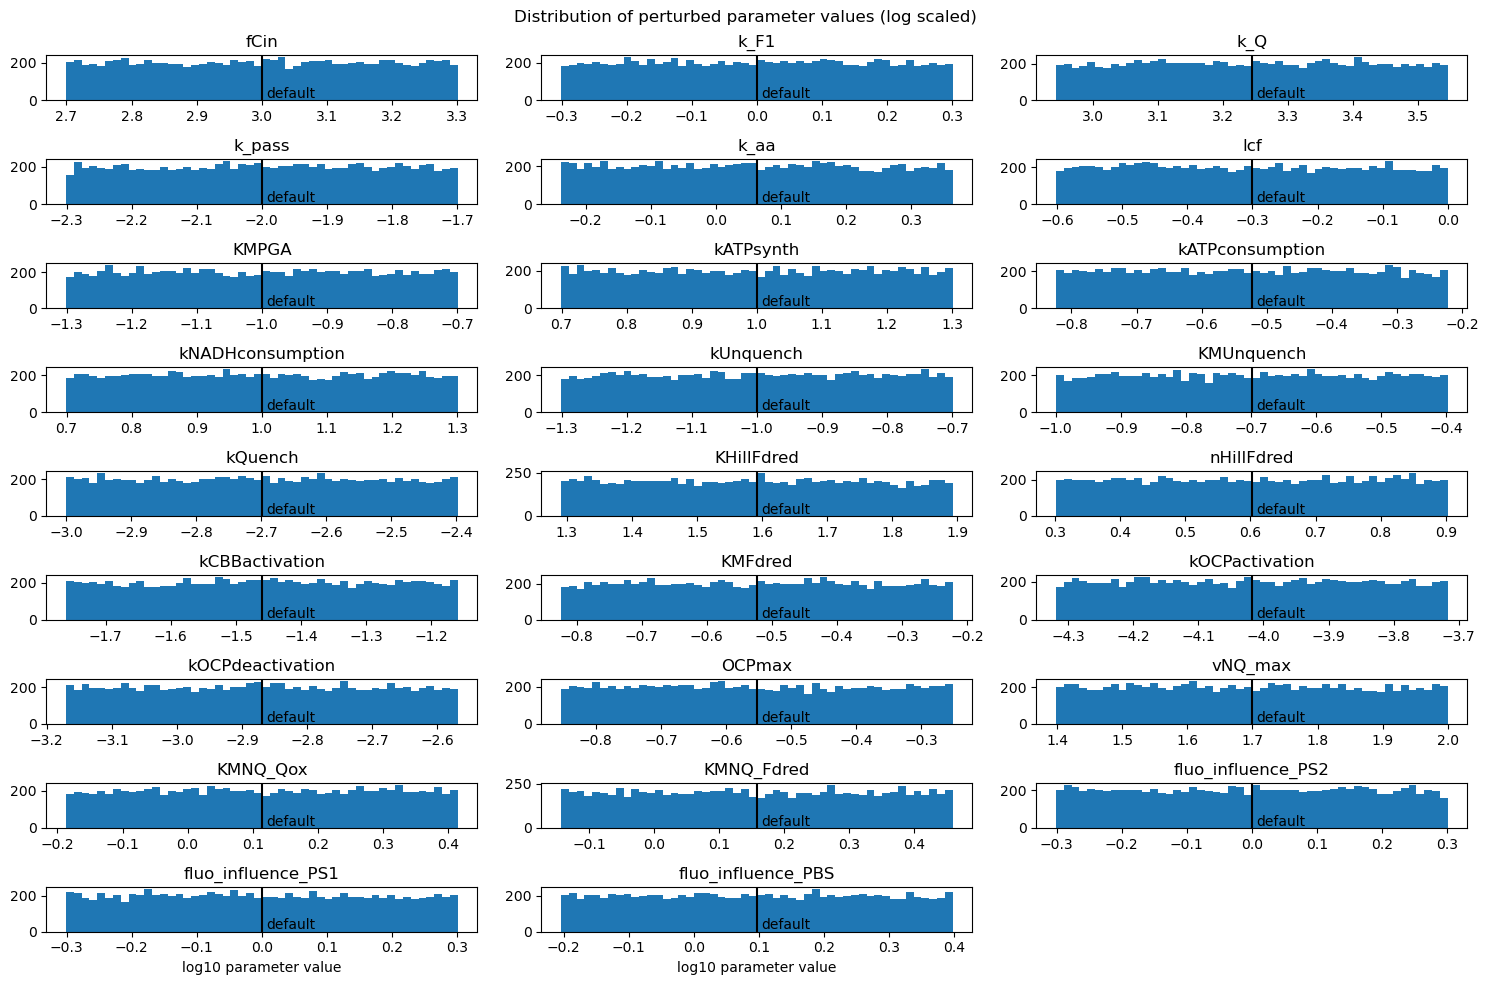

In [145]:
# Plot the parameter distribution
ncols = 3
nrows = int(np.ceil(mcpar_flat.shape[1]/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize = (15,10))

for (nam, val), ax in zip(mcpar_flat.T.iterrows(), axes.flatten()):
    ax.hist(np.log10(val), bins=50)
    ax.set_title(nam)

    ax.axvline(np.log10(val[0]), c="k")
    ax.text(0.51, 0.05, "default", transform = ax.transAxes)

# Label the lowest x axes
for i in range(ncols):
    axes[-1,i].set_xlabel("log10 parameter value")

# Remove unused axes
if ncols * nrows > mcpar_flat.shape[1]:
    for i in range(mcpar_flat.shape[1], ncols * nrows):
        axes.flatten()[i].remove()

fig.suptitle("Distribution of perturbed parameter values (log scaled)")

fig. tight_layout()

In [ ]:
# Visualise with single output
nrows = 7
fig, _axes = plt.subplots(nrows, int(np.ceil((mcpar_flat.shape[1]+1) / nrows)), figsize=(15,15))
axes = _axes.flatten()

plot_type = "scatter"

# Plot the overall distribution
axes[0].hist(mcres[mcres_succ], bins=100, orientation="horizontal")
axes[0].set_xlabel("Frequency")

for i, (nam, vals) in enumerate(mcpar_flat.T.iterrows()):

    if plot_type == "scatter":
        axes[i+1].plot(
            vals[mcres_succ],
            mcres[mcres_succ],
            marker="o",
            ls="",
            markersize=1
        )
        axes[i+1].set_xscale("log")
    elif plot_type == "hex":
        axes[i+1].hexbin(
            np.log10(vals[mcres_succ]),
            mcres[mcres_succ],
        )

    # axes[i+1].plot(
    #     vals[0],
    #     mcres[0],
    #     marker="o",
    #     ls="",
    #     markersize=3,
    #     c="red"
    # )

    axes[i+1].set_xlabel(nam)

# Add the y label
_axes[nrows//2, 0].set_ylabel("Root mean squared residuals [AU]")

# Add a title and improve the layout
fig.suptitle("Residuals under parameter variation")
fig.tight_layout()


plt.show(fig)
plt.close()

# Local optimisation

In [147]:
with open("../Results/minimise_202405081435_results.pickle", "rb") as f:
    fit = pickle.load(f)

In [148]:
fit

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.8749066815949099
             x: [ 1.011e+03  1.089e+00 ...  1.299e+00  1.416e+00]
           nit: 661
          nfev: 1141
 final_simplex: (array([[ 1.011e-02,  1.089e-02, ...,  9.990e-03,
                         9.842e-03],
                       [ 1.011e-02,  1.089e-02, ...,  9.990e-03,
                         9.842e-03],
                       ...,
                       [ 1.011e-02,  1.089e-02, ...,  9.989e-03,
                         9.842e-03],
                       [ 1.011e-02,  1.089e-02, ...,  9.989e-03,
                         9.842e-03]]), array([ 8.749e-01,  8.749e-01, ...,  8.750e-01,  8.750e-01]))

In [149]:
p_optim = get_fitting_parameter_dict(fit.x, p_names)

In [ ]:
test = calculate_residuals(p_optim, save_intermediates=False, return_all=True)

In [ ]:
test[1].shape

In [ ]:
residuals = pd.DataFrame(index=np.arange(7), columns=[1,2,3])

In [ ]:
residuals

In [ ]:
test = pd.Series({1:2, 2:4, 3:6})
test2 = pd.Series({2:"a", 3:"b", 1:"c"})

In [ ]:
from pathlib import Path

In [ ]:
Path("../Results/202404171132_CO2production_wi.dill").is_file()

In [ ]:
test

In [ ]:
",".join(test.values.astype(str))

In [ ]:
residuals.loc[0,:] = test

In [ ]:
residuals.loc[1,:] = test2

In [ ]:
residuals